# Applying Sindy-SHRED to the C. elegan Dataset 

Data obtained from Global Brain Dynamics Embed the Motor Command Sequence of Caenorhabditis elegans. Cell, 163(3), 656–669. http://doi.org/10.1016/j.cell.2015.09.034

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

SINDy-SHRED further extends the SHRED architecture by integrating **Sparse Identification of Nonlinear Dynamics (SINDy)** into the recurrent decoder framework. The key idea is to enforce a **parsimonious latent space representation**, where the dynamics of the latent variables are governed by a **sparse set of basis functions**.

More formally, SINDy-SHRED introduces an additional inductive bias:

$$\dot{z} = \Theta(z) \xi$$

where:

- $z = \mathcal{G} \left( \{ y_i \} _{i=t-k}^t \right)$ represents the **latent space variables** extracted by the LSTM encoder.
- $\Theta(z)$ is a **library of candidate nonlinear functions**.
- $\xi$ is a **sparse coefficient matrix** that determines the governing equations.

This combination enables **interpretable spatio-temporal modeling** by ensuring that the learned representations adhere to a **governing law**, making the method suitable for **data-driven discovery of dynamical systems** from high-dimensional, noisy observations.

In this notebook, we will walk through the application of **SINDy-SHRED** on the **teenage control MEG dataset**, demonstrating how the model can **learn a reduced-order latent representation** and **recover the governing equations** that describe brain dynamics.

In [2]:
# Clone the GitHub Repository
## git clone https://github.com/gaoliyao/sindy-shred.git
## pip install pysindy==1.7.5 numpy==1.23.5 scipy==1.13.1 scikit-learn==1.5.2

In [118]:
# Importing all dependencies 
import numpy as np
import numpy as np
import torch
import subprocess
import os
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
import mne
from scipy.signal import butter, filtfilt
from scipy.signal import welch
from scipy.interpolate import CubicSpline
from scipy.io import loadmat
from sklearn.linear_model import Ridge
from scipy.signal import butter, filtfilt
from scipy.signal import savgol_filter



In [2]:
#Importing packages
# Change into the directory
os.chdir("/home/amy/SHRED_neuro/sindy-shred") ## Change to where the repo was cloned

from processdata import load_data
from processdata import TimeSeriesDataset
import sindy
import pysindy as ps
from pysindy.differentiation import FiniteDifference

os.environ["CUDA_VISIBLE_DEVICES"]="0"


# Data Format
- 5 worms
- 18 mins at roughly 2.85 samples per second --> ~3000 samples per trial
- 107 - 131 neurons

*Worm One, No Stim*

In [9]:
!ls

neuroenv  sindy-shred  worms


In [19]:
# Loading the Dataset
# os.chdir("../")
os.chdir("../")

data_path = 'worms/worm_data/WT_Stim.mat'
data = loadmat(data_path)
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'AVA_HisCl', 'WT_NoStim', 'WT_Stim'])


In [20]:
# Working with the no stim condition -- WORM ONE
no_stim = data['WT_NoStim']
neuron_data = no_stim[0][0][0] #3137 timepoints, 109 neurons 

time = no_stim[0][0][4]
dt = time[1][0] - time[0][0]

m = neuron_data.shape[0] # number of timepoints
n = neuron_data.shape[1] #number of neurons 

neuron_data_cor = no_stim[0][0][1]

neuron_name = []
for i in range((n-1)):
    neuron_name.append(no_stim[0][0][3][0][i][0])

sr = no_stim[0][0][6]
# Movement Classifications;  
# ‘FWD’ forward crawling ‘SLOW’ forward slowing ‘DT’ dorsal post reversal turn ‘VT’ ventral post reversal turn 
# ‘REV1’ reverse crawling ‘REV2’ reverse crawling ‘REVSUS’ sustained reverse crawling ‘NOSTATE’ - ambiguous
FWD = no_stim[0][0][7][0][0][0]
SLOW = no_stim[0][0][7][0][0][1]
DT = no_stim[0][0][7][0][0][2]
VT = no_stim[0][0][7][0][0][3]
REV1 = no_stim[0][0][7][0][0][4]
REV2 = no_stim[0][0][7][0][0][5]
REVSUS = no_stim[0][0][7][0][0][6]
NOSTATE = no_stim[0][0][7][0][0][7]

print(m,n)
print(time[-1])
print(sr)


3137 109
[1079.65572203]
[[2.90462963]]


In [22]:
print(neuron_data_cor)
print(neuron_data_cor[1,0])
load_X = neuron_data_cor

[[0.1971036  0.2772512  0.15407247 ... 0.46837034 0.25607834 0.3582931 ]
 [0.19316978 0.27975053 0.16162942 ... 0.4435926  0.27620445 0.36292656]
 [0.20246483 0.28147009 0.147317   ... 0.4720659  0.23780916 0.37709276]
 ...
 [0.08095081 0.15935624 0.05726877 ... 0.25223605 0.12992515 0.24421274]
 [0.08161957 0.12314727 0.09515152 ... 0.24836015 0.1103177  0.22273175]
 [0.0622557  0.16723433 0.074167   ... 0.22582504 0.10068002 0.22036835]]
0.19316977771053434


Randomly select n number of neurons and prepare the train, test, and validation sets. sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets.

Text(0, 0.5, 'Neurons')

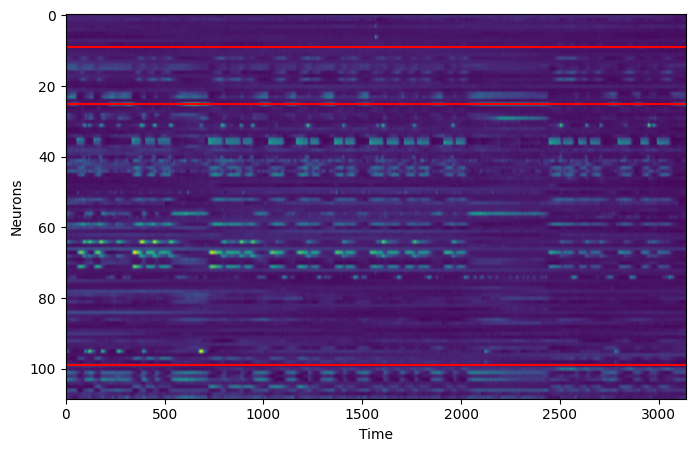

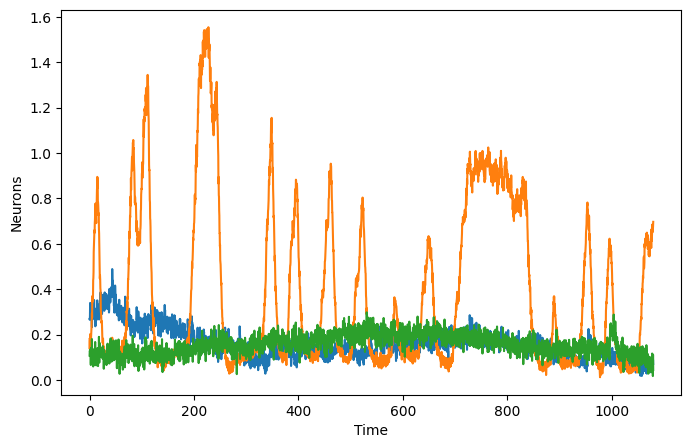

In [23]:
num_neurons = 3 
lags = 100

# Randomly select the neurons to train the SHRED model on
# neuron_locations = np.random.choice(n, size= num_neurons, replace=False) 
neuron_locations = np.array([99, 25, 9])
plt.figure(figsize = (8,5))
plt.imshow(load_X.T, aspect = 'auto')
plt.xlabel('Time')
plt.ylabel('Neurons')

for i in range(neuron_locations.shape[0]):
  plt.axhline(neuron_locations[i], color = 'red')


plt.figure(figsize = (8,5))
plt.plot(time, load_X[:,neuron_locations])
plt.xlabel('Time')
plt.ylabel('Neurons')

In [14]:
print(neuron_locations)

[99  9 25]


Text(0, 0.5, 'Neurons')

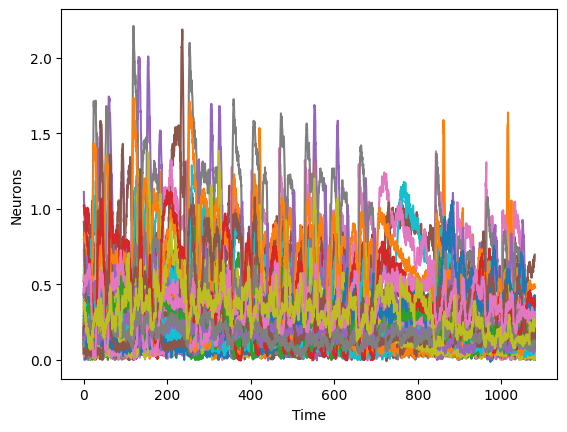

In [8]:
plt.plot(time, load_X)
plt.xlabel('Time')
plt.ylabel('Neurons')



In [ ]:
## Testing out filtering processes
latent_dim = 60
poly_order = 1
include_sine = True
library_dim = sindy.library_size(latent_dim, poly_order, include_sine, True)
os.chdir("/home/amy/SHRED_neuro/sindy-shred")
import sindy_shred

for k in range(4):
    load_X_s = load_X[k*(750):(k+1)*(750)]
    test_val_size = 150
    m=750
    train_indices = np.arange(0, 750 - lags - test_val_size)
    mask = np.ones(m - lags)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, m - lags)[np.where(mask!=0)[0]]
    valid_indices = valid_test_indices[:int(test_val_size/2)]
    test_indices = valid_test_indices[int(test_val_size/2):test_val_size]
    sc = MinMaxScaler()
    sc = sc.fit(load_X_s[train_indices])
    transformed_X = sc.transform(load_X_s)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((m - lags, lags, num_neurons))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, neuron_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    for z in range(10):
        shred = sindy_shred.SINDy_SHRED(num_neurons, n, hidden_size=latent_dim, hidden_layers=2, l1=350, l2=400, dropout=0.1,
                                        library_dim=library_dim, poly_order=poly_order,
                                        include_sine=include_sine, dt=dt, layer_norm=False).to(device)

        validation_errors = sindy_shred.fit(shred, train_dataset, valid_dataset, batch_size=128, num_epochs=200,
                                            lr=1e-3, verbose=True, threshold=0.25, patience=5, sindy_regularization=10.0,
                                            optimizer="AdamW", thres_epoch=100)
        
        test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
        test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
        mse_test = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
        
        train_recons = sc.inverse_transform(shred(train_dataset.X).detach().cpu().numpy())
        train_ground_truth = sc.inverse_transform(train_dataset.Y.detach().cpu().numpy())
        mse_train = np.linalg.norm(train_recons - train_ground_truth) / np.linalg.norm(train_ground_truth)

        file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_one_test_recons{k}_{z}.npy"
        np.save(file_path, test_recons)
        file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_one_train_recons{k}_{z}.npy"
        np.save(file_path, train_recons)
        file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_one_test_gt{k}_{z}.npy"
        np.save(file_path, test_ground_truth)
        file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_one_train_gt{k}_{z}.npy"
        np.save(file_path, train_ground_truth)
        file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_one_mse{k}_{z}.npy"
        np.save(file_path, [mse_test, mse_train])




1 : tensor(0.2473, device='cuda:0', grad_fn=<AddBackward0>)
2 : tensor(0.1388, device='cuda:0', grad_fn=<AddBackward0>)
3 : tensor(0.0849, device='cuda:0', grad_fn=<AddBackward0>)
4 : tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)
5 : tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>)
6 : tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)
7 : tensor(0.0602, device='cuda:0', grad_fn=<AddBackward0>)
8 : tensor(0.0588, device='cuda:0', grad_fn=<AddBackward0>)
9 : tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)
10 : tensor(0.0609, device='cuda:0', grad_fn=<AddBackward0>)
11 : tensor(0.0603, device='cuda:0', grad_fn=<AddBackward0>)
12 : tensor(0.0592, device='cuda:0', grad_fn=<AddBackward0>)
13 : tensor(0.0582, device='cuda:0', grad_fn=<AddBackward0>)
14 : tensor(0.0585, device='cuda:0', grad_fn=<AddBackward0>)
15 : tensor(0.0589, device='cuda:0', grad_fn=<AddBackward0>)
16 : tensor(0.0585, device='cuda:0', grad_fn=<AddBackward0>)
17 : tensor(0.0577, device='cuda:

In [ ]:
### Get data- Segment One
test_recons_one = []
for k in range(10):
    data  = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_one/exp_one_test_recons0_{k}.npy")
    test_recons_one.append(data)

test_gt_one = []
for k in range(10):
    data  = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_one/exp_one_test_gt0_{k}.npy")
    test_gt_one.append(data)

train_recons_one = []
for k in range(10):
    data  = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_one/exp_one_train_recons0_{k}.npy")
    train_recons_one.append(data)

train_gt_one = []
for k in range(10):
    data  = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_one/exp_one_train_gt0_{k}.npy")
    train_gt_one.append(data)

mse_one = []
for k in range(10):
    data  = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_one/exp_one_mse0_{k}.npy")
    mse_one.append(data)


In [ ]:
print(mse_one)

[array([0.5219072 , 0.20473008], dtype=float32), array([0.533444  , 0.19832996], dtype=float32), array([0.5677506, 0.2013718], dtype=float32), array([0.5344825, 0.167594 ], dtype=float32), array([0.5161791 , 0.19968762], dtype=float32), array([0.57223874, 0.21248308], dtype=float32), array([0.4668245, 0.1701453], dtype=float32), array([0.5573794 , 0.19056524], dtype=float32), array([0.46523452, 0.17914964], dtype=float32), array([0.5265707 , 0.20252103], dtype=float32)]


## Test Dataset

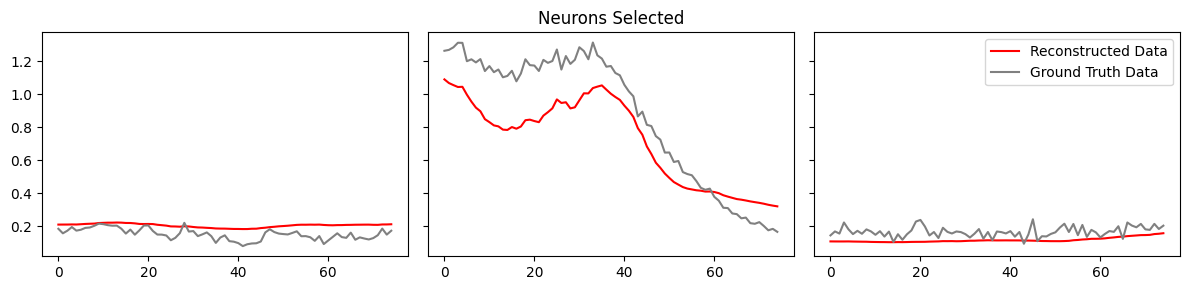

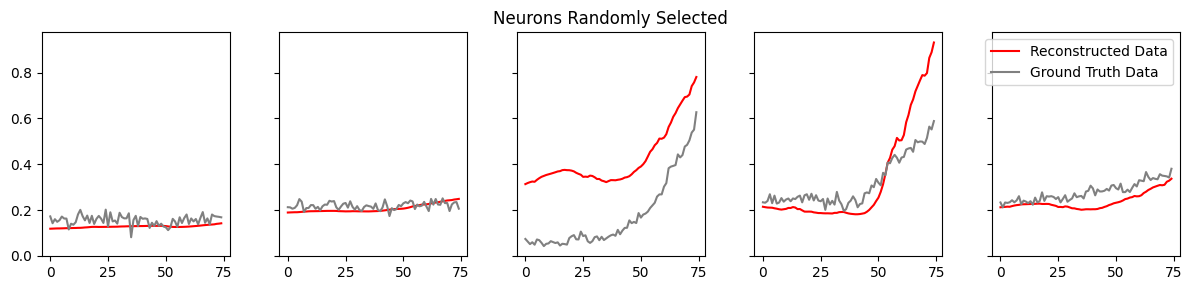

In [43]:
### Reconstructed and ground truth Activity Traces - selected neurons
fig, axes = plt.subplots(1,num_neurons, figsize=(12, 3), sharex=True, sharey=True)
for i in range(num_neurons):
    axes[i].plot(test_recons_one[4][:, neuron_locations[i]], label = "Reconstructed Data", color = 'red')
    axes[i].plot(test_gt_one[4][:, neuron_locations[i]], label = 'Ground Truth Data', color = 'grey')
    axes[1].set_title('Neurons Selected')
plt.legend()
plt.tight_layout()
plt.show()


### Reconstructed and ground truth Activity Traces - random neurons
# neuron_loc_graph = np.random.choice(n, size= 5, replace=False) 
neuron_loc_graphh = np.array([84, 62, 66, 25, 18])
fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharex=True, sharey=True)
for i in range(5):
    axes[i].plot(test_recons_one[4][:, neuron_loc_graph[i]], label = "Reconstructed Data", color = 'red')
    axes[i].plot(test_gt_one[4][:, neuron_loc_graph[i]], label = 'Ground Truth Data', color ='grey')
    axes[2].set_title('Neurons Randomly Selected')
plt.legend()
plt.tight_layout()
plt.show()

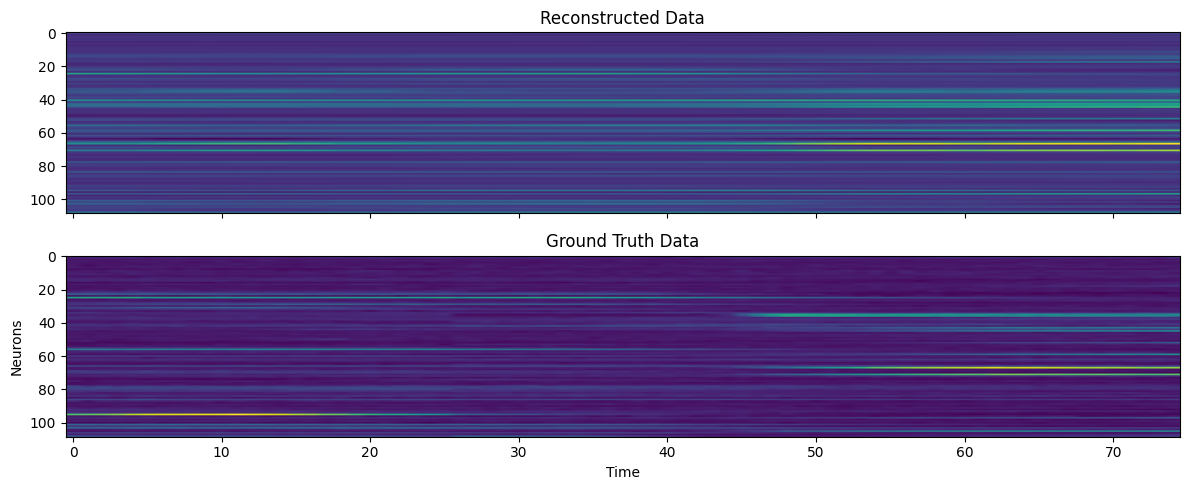

In [246]:
### Reconstructed and ground truth Carpet Plot
fig, axes = plt.subplots(2, figsize=(12, 5), sharex=True, sharey=True)
# Plot the reconstructed data
axes[0].imshow(test_recons_one[5].T, aspect='auto')
axes[0].set_title("Reconstructed Data")
# Plot the ground truth data
axes[1].imshow(test_gt_one[5].T, aspect='auto')
axes[1].set_title("Ground Truth Data")
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Neurons')


plt.tight_layout()
plt.show()

## Train Dataset

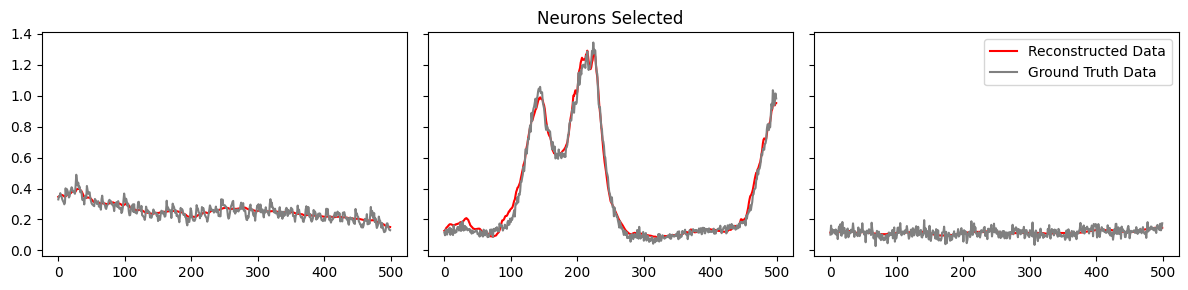

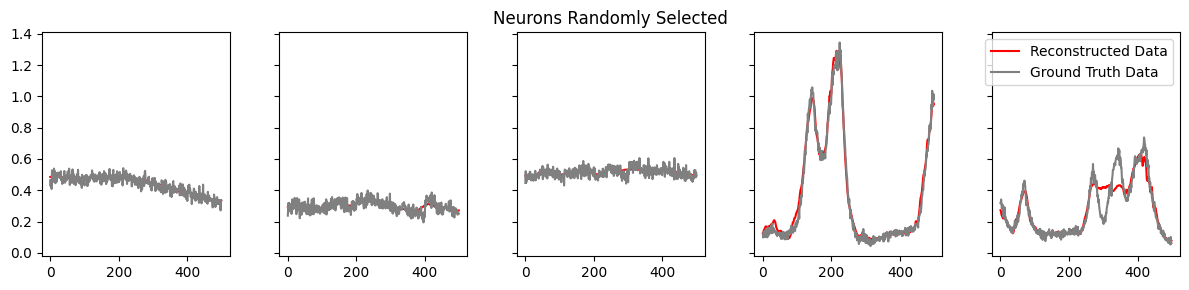

In [189]:
### Reconstructed and ground truth Activity Traces - selected neurons
fig, axes = plt.subplots(1,num_neurons, figsize=(12, 3), sharex=True, sharey=True)
for i in range(num_neurons):
    axes[i].plot(train_recons_one[4][:, neuron_locations[i]], label = "Reconstructed Data", color = 'red')
    axes[i].plot(train_gt_one[4][:, neuron_locations[i]], label = 'Ground Truth Data', color = 'grey')
    axes[1].set_title('Neurons Selected')
plt.legend()
plt.tight_layout()
plt.show()


### Reconstructed and ground truth Activity Traces - random neurons
# neuron_loc_graph = np.random.choice(n, size= 5, replace=False) 
neuron_loc_graph = np.array([84, 62, 66, 25, 18])

fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharex=True, sharey=True)
for i in range(5):
    axes[i].plot(train_recons_one[4][:, neuron_loc_graph[i]], label = "Reconstructed Data", color = 'red')
    axes[i].plot(train_gt_one[4][:, neuron_loc_graph[i]], label = 'Ground Truth Data', color ='grey')
    axes[2].set_title('Neurons Randomly Selected')
plt.legend()
plt.tight_layout()
plt.show()

# Comparing to filtered data

(3137, 109)
(129, 109)


Text(0.5, 1.0, 'PSD of New Data')

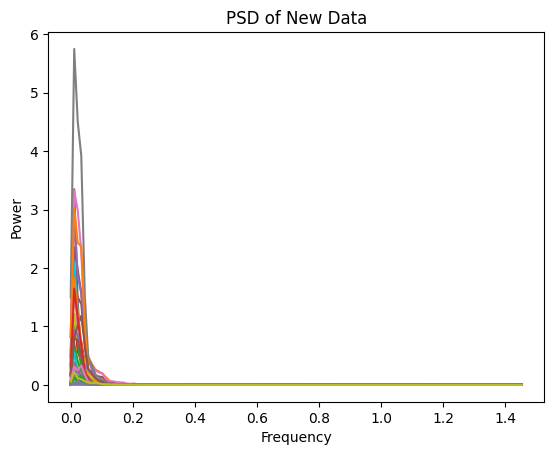

In [291]:
#Calculating the PSD of the Data
print(load_X.shape)
freqs, psd = welch(load_X, fs=sr, axis=0)
plt.plot(freqs[0], psd)
# plt.xlim([0,0.2])
print(psd.shape)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('PSD of New Data')


In [ ]:
#Butterworth Filter
b, a = butter(N=3, Wn=sr[0][0]/2.01, btype = 'low', fs = sr[0][0] )  # Example: low-pass filter
filtered_bw = filtfilt(b, a, train_gt_one[0])


# Savitzky-Golay Filter
filtered_sg = savgol_filter(train_gt_one[0], window_length=5, polyorder=4)

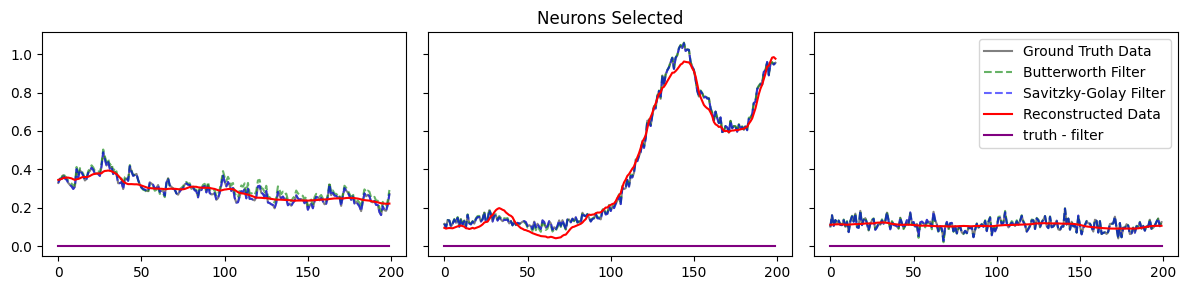

(500, 109)


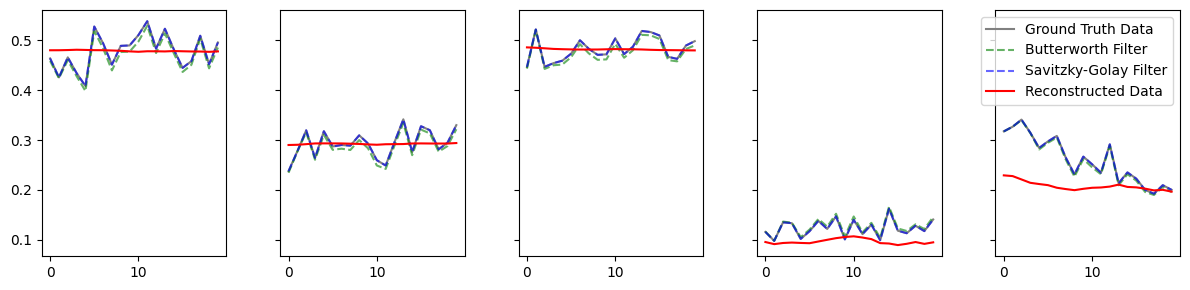

In [ ]:
### Reconstructed and ground truth Activity Traces - selected neurons
fig, axes = plt.subplots(1,num_neurons, figsize=(12, 3), sharex=True, sharey=True)
for i in range(num_neurons):
    axes[i].plot(train_gt_one[0][:200, neuron_locations[i]], label = 'Ground Truth Data', color = 'grey')
    axes[i].plot(filtered_bw[:200 , neuron_locations[i]], label = 'Butterworth Filter', color = 'green', alpha = 0.6, linestyle = '--')
    axes[i].plot(filtered_sg[:200 , neuron_locations[i]], label = 'Savitzky-Golay Filter', color = 'blue', alpha = 0.6, linestyle = '--')
    axes[i].plot(train_recons_one[0][:200, neuron_locations[i]], label = "Reconstructed Data", color = 'red')
    axes[i].plot(train_gt_one[0][:200, neuron_locations[i]] - filtered_sg[:200 , neuron_locations[i]], label = 'truth - filter', color = 'purple')


    axes[1].set_title('Neurons Selected')
plt.legend()
plt.tight_layout()
plt.show()

print(train_recons_one[0].shape)


### Reconstructed and ground truth Activity Traces - random neurons
# neuron_loc_graph = np.random.choice(n, size= 5, replace=False) 
neuron_loc_graph = np.array([84, 62, 66, 25, 18])

fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharex=True, sharey=True)
for i in range(5):
    axes[i].plot(train_gt_one[0][:20, neuron_loc_graph[i]], label = 'Ground Truth Data', color = 'grey')
    axes[i].plot(filtered_bw[:20 , neuron_loc_graph[i]], label = 'Butterworth Filter', color = 'green', alpha = 0.6, linestyle = '--')
    axes[i].plot(filtered_sg[:20 , neuron_loc_graph[i]], label = 'Savitzky-Golay Filter', color = 'blue', alpha = 0.6, linestyle = '--')
    axes[i].plot(train_recons_one[0][:20, neuron_loc_graph[i]], label = "Reconstructed Data", color = 'red')
plt.legend()
plt.tight_layout()
plt.show()

In [308]:
#Butterworth Filter
b, a = butter(N=3, Wn=0.2, btype = 'low', fs = sr[0][0] ) 
filtered_bw = filtfilt(b, a, train_gt_one[3], axis =0)


# Savitzky-Golay Filter
filtered_sg = savgol_filter(train_gt_one[0], window_length=30, polyorder=3)

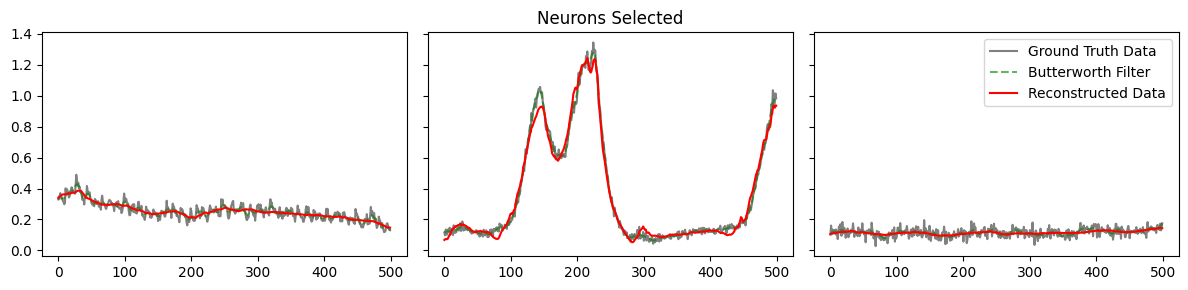

(500, 109)


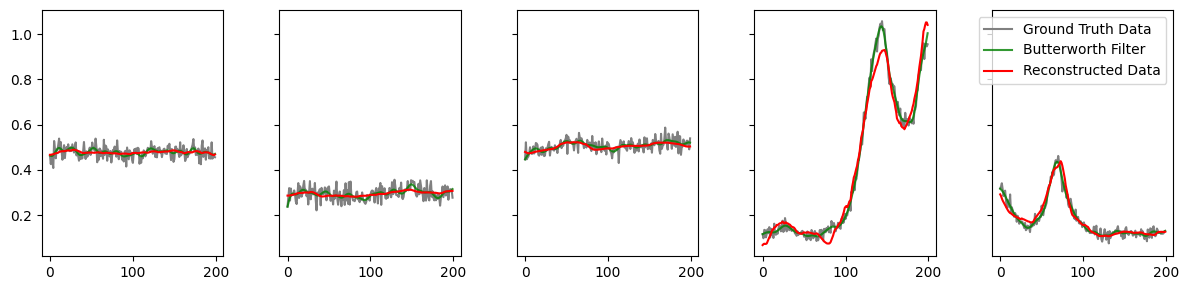

In [309]:
### Reconstructed and ground truth Activity Traces - selected neurons
fig, axes = plt.subplots(1,num_neurons, figsize=(12, 3), sharex=True, sharey=True)
for i in range(num_neurons):
    axes[i].plot(train_gt_one[3][:, neuron_locations[i]], label = 'Ground Truth Data', color = 'grey')
    axes[i].plot(filtered_bw[: , neuron_locations[i]], label = 'Butterworth Filter', color = 'green', alpha = 0.6, linestyle = '--')
    # axes[i].plot(filtered_sg[:200 , neuron_locations[i]], label = 'Savitzky-Golay Filter', color = 'blue', alpha = 0.6, linestyle = '--')
    axes[i].plot(train_recons_one[3][:, neuron_locations[i]], label = "Reconstructed Data", color = 'red')

    # axes[i].plot(train_gt_one[0][:, neuron_locations[i]] - filtered_bw[: , neuron_locations[i]], label = 'Ground Truth Data', color = 'purple')


    axes[1].set_title('Neurons Selected')
plt.legend()
plt.tight_layout()
plt.show()

print(train_recons_one[0].shape)


### Reconstructed and ground truth Activity Traces - random neurons
# neuron_loc_graph = np.random.choice(n, size= 5, replace=False) 
neuron_loc_graph = np.array([84, 62, 66, 25, 18])

fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharex=True, sharey=True)
for i in range(5):
    axes[i].plot(train_gt_one[3][:200, neuron_loc_graph[i]], label = 'Ground Truth Data', color = 'grey')
    axes[i].plot(filtered_bw[:200 , neuron_loc_graph[i]], label = 'Butterworth Filter', color = 'green', alpha = 0.8)
    # axes[i].plot(filtered_sg[: , neuron_loc_graph[i]], label = 'Savitzky-Golay Filter', color = 'blue', alpha = 0.6, linestyle = '--')
    axes[i].plot(train_recons_one[3][:200, neuron_loc_graph[i]], label = "Reconstructed Data", color = 'red')
plt.legend()
plt.tight_layout()
plt.show()

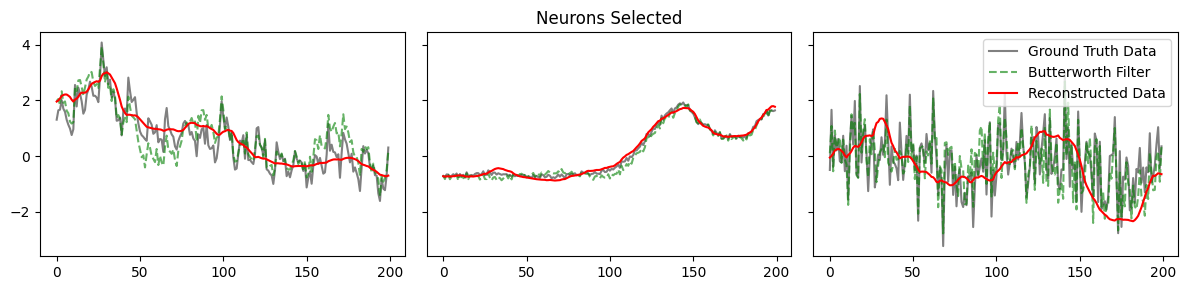

(500, 109)


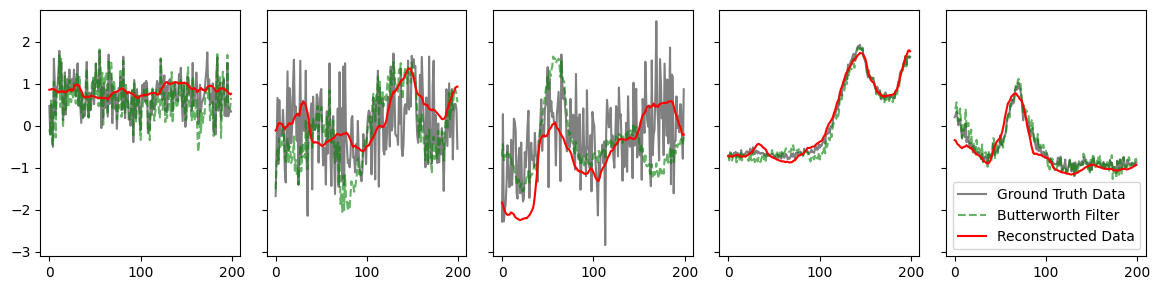

In [ ]:
centered_train_gt = (train_gt_one[0] - np.mean(train_gt_one[0], axis = 0))/ np.std(train_gt_one[0], axis = 0)
centered_train_bw = (filtered_bw - np.mean(filtered_bw, axis = 0))/ np.std(filtered_bw, axis = 0)
centered_train_recon = (train_recons_one[0] - np.mean(train_recons_one[0], axis = 0))/ np.std(train_recons_one[0], axis = 0)


### Reconstructed and ground truth Activity Traces - selected neurons
fig, axes = plt.subplots(1,num_neurons, figsize=(12, 3), sharex=True, sharey=True)
for i in range(num_neurons):
    axes[i].plot(centered_train_gt[:200, neuron_locations[i]], label = 'Ground Truth Data', color = 'grey')
    axes[i].plot(centered_train_bw[:200 , neuron_locations[i]], label = 'Butterworth Filter', color = 'green', alpha = 0.6, linestyle = '--')
    axes[i].plot(centered_train_recon[:200, neuron_locations[i]], label = "Reconstructed Data", color = 'red')


    axes[1].set_title('Neurons Selected')
plt.legend()
plt.tight_layout()
plt.show()

print(train_recons_one[0].shape)


### Reconstructed and ground truth Activity Traces - random neurons
# neuron_loc_graph = np.random.choice(n, size= 5, replace=False) 
neuron_loc_graph = np.array([84, 62, 66, 25, 18])

fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharex=True, sharey=True)
for i in range(5):
    axes[i].plot(centered_train_gt[:200, neuron_loc_graph[i]], label = 'Ground Truth Data', color = 'grey')
    axes[i].plot(centered_train_bw[:200 , neuron_loc_graph[i]], label = 'Butterworth Filter', color = 'green', alpha = 0.6, linestyle = '--')
    axes[i].plot(centered_train_recon[:200, neuron_loc_graph[i]], label = "Reconstructed Data", color = 'red')
plt.legend()
plt.tight_layout()
plt.show()